In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import  mean_pinball_loss

import requests
from datetime import datetime, date, timedelta
from tqdm import tqdm

import ephem

In [2]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [3]:
# Create dataframe
df_raw = get_energy_data()
df_raw = df_raw.rename(columns={"Netzlast_Gesamt": "gesamt"})
# df_raw['gesamt'] = df_raw['gesamt'] / 1000

  0%|          | 0/275 [00:00<?, ?it/s]C:\Users\Bilal\AppData\Local\Temp\ipykernel_13016\2279548712.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 275/275 [00:38<00:00,  7.09it/s]


In [6]:
# filter data
start_dt = '2019-01-01 00:00:00'
end_dt = '2023-11-15 23:00:00'
df = df_raw.copy()
df = df.loc[(df.index >= start_dt) & (df.index <= end_dt)]
df

,gesamt
date_time,
2019-01-01 00:00:00,43265.50
2019-01-01 01:00:00,41654.00
2019-01-01 02:00:00,40113.75
2019-01-01 03:00:00,39313.00
2019-01-01 04:00:00,39097.25
...,...
2023-11-15 19:00:00,65460.25
2023-11-15 20:00:00,62232.50
2023-11-15 21:00:00,59061.00


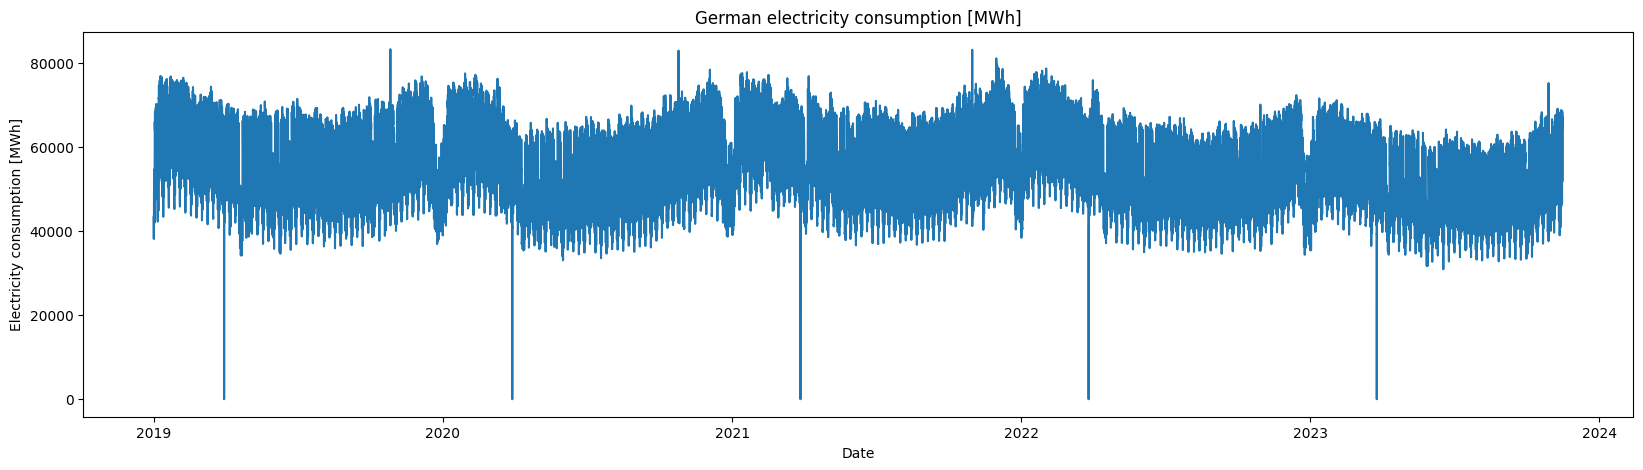

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df['gesamt'])

plt.xlabel('Date')
plt.ylabel('Electricity consumption [MWh]')
plt.title('German electricity consumption [MWh]')
plt.show()

In [8]:
df_subset = df.copy()

In [ ]:
df_subset

In [ ]:
plt.figure(figsize=(20,5))
df_subset = df.copy()
plt.plot(df_subset['timestamp_CET'], df_subset['gesamt'])

# add grey vertical lines at each new day
for i in range(8):
    plt.axvline(x=df_subset.index[i*24], color='grey', linestyle='-')
    if i < 7: plt.axvline(x=df_subset.index[i*24 + 12], color='grey', linestyle='--', alpha=0.3)


plt.axvspan(df_subset.index[5*24], df_subset.index[7*24], color='red', alpha=0.1, label='weekend')

plt.ylim(32_000, 75_000)
plt.xlabel('Time')
plt.ylabel('Energy consumption [MWh]')
plt.legend(loc='upper right')
plt.title('German energy consumption in 2023 week 45 from Monday to Sunday [MWh]')

# Save plot as PDF
plt.tight_layout()
plt.savefig("energy_data_weekly.pdf")
plt.show()